# Manual matrix multiplication
We want to build an output matrix that contains 5 components each and has the same number of rows as our
transformation matrix. This follows the invariant that the number of rows in the transformation matrix
will determine the number of dimensions of our output matrix. Transformation matrix (10, 3) => output matrix (10, )
We are adding the stipulation however, that each of the exposures in our input vector has 5 assets, therefore our
output matrix, must contain the same number of rows as our transformation matrix, but must also have 5 columns
one for each of our assets. Thus we build an blank array that is 5 components long [0.0, 0.0, 0.0, 0.0, 0.0] and repeat this
for the total length of the rows in our transformation matrix.

We start by iterating over the rows. Starting with row[0], we access the following elements of our blank array, input vector and transformation matrix.
matrix[i][j] => corresponds to each of the row, column pairs we have. Starting with row[0], col[0] of our transformation matrix,
the transformation has to be applied to each component in the input column for asset j.
So within col[0] of our input vector we apply matrix[0][0] to v[0][0], then we apply matrix[0][1] to v[1][0] and so on. This allows each assets exposure to factor j to be multiplyed by the corresponding factor [j] at time [i].
This is then summed along time [i] to get an assets return for v[0][0] which would be the sum of matrix[0][0] * v[0][0] + matrix[0][1] * v[1][0] + matrix[0][2] * v[2][0], before iterating to the next asset (k) and repeating the matrix mul.

In [36]:
import logging

import numpy as np

np.random.seed(20)

class Matrix:
    def __init__(self, matrix: list[list[float]]):
        self.matrix = matrix
        self.rows = len(matrix)
        self.cols = len(matrix[0])

    def __check_dimensions(self):
        if any(len(col) != self.cols for col in self.matrix):
            raise ValueError("All rows must have the same number of columns.")

    def __check_vector_dimensions(self, v: list[float]):
        if len(v) != self.cols:
            raise ValueError("Input matrix must have the same number of factor exposures - rows - (for each asset) as factor matrix has factors.")

    def _batch_handler(self, m: list):

        v_len = len(m[0])
        v_r = [[0.0] * v_len for _ in range(self.rows)]

        for i in range(self.rows):
            for k in range(v_len):
                for j in range(self.cols):
                    v_r[i][k] += self.matrix[i][j] * m[j][k]

        return v_r

    def _vec_mat_mul(self, v: list[float]):
        v_r = [0.0] * self.rows
        for i in range(self.rows):
            for j in range(self.cols):
                v_r[i] += self.matrix[i][j] * v[j]

        return v_r


    def _mul_handler(self, v_m: list):

        try:
            self.__check_dimensions()
        except ValueError as e:


        if len(v_m[0]) != 1:
            print("Handling mat x mat multiplication")
            v_r = self._batch_handler(v_m)
            return v_r
        else:
            print("Handling mat x vec multiplication")
            v_r = self._vec_mat_mul(v_m)
            return v_r




T, K, N = 10, 3, 5
factors = np.random.normal(0, 1, size=(T, K)).tolist()


B_true = np.array([
    [1.2, 0.5, -0.3, 0.0, 1.0],  # Market
    [0.8, -0.2, 0.4, 1.1, -0.5],  # Size
    [0.1, 0.6, 0.9, 0.2, 0.0],  # Value
]).tolist()

m1 = Matrix(factors)
tm1 = m1.mat_mul(B_true)
print(tm1[0])

[1.2531174043594595, 0.617295461432316, 0.1349609393266122, 0.28695882741846673, 0.7859606015985234]


# Simplifiation to Visualize

We're going to visualize two different operations. The first will be R10 for an individual asset and the second will be R10 5 times, for each of the individual assets in R10 space.

I will first visualize an individual asset to get an understanding of the concepts before visualizing each asset in the same space along the individual time slices. So first, one asset over 10 time slices, and then 5 assets per time slice for each of the time slices.

In [63]:

## In this case we'll begin to use numpy as it's a bit cleaner
np.random.seed(20)
T, K, N = 20, 3, 5
factors = np.random.normal(0, 1, size=(T, K))


B_true = np.array([
    [1.2, 0.5, -0.3, 0.0, 1.0],  # Market
    [0.8, -0.2, 0.4, 1.1, -0.5],  # Size
    [0.1, 0.6, 0.9, 0.2, 0.0],  # Value
])

epsilon = np.random.normal(0, 0.6, size=(T, N))

R = factors @ B_true + epsilon
pR = factors @ B_true
print(R[0], pR[0]) #using a simple example as the purpose is to visualize and understand -> adding slight noise to get some residual between predicted and actual returns

[0.75590174 0.68572402 0.45159802 0.38046176 1.56681824] [1.2531174  0.61729546 0.13496094 0.28695883 0.7859606 ]


In [64]:
# I will need first utilize the just asset[0]

#Retrieve asset 0's real returns
R_0 = np.array([r[0] for r in R.tolist()])

#Retrieve asset 0's predicted returns'
pR_0 = np.array([p[0] for p in pR.tolist()])

# Calculate residuals
residuals = np.array([r - p for r, p in zip(R_0, pR_0)])
print(residuals)

[-0.49721566 -0.59688114  0.05927317 -0.28947055  0.02291548  0.86844423
  0.65726001 -1.08915348 -0.31924755 -0.94575293  0.65513197 -0.80095246
  0.17373549 -0.06699438  0.0067388   0.15093173  0.20909332  0.35664926
  0.36595068 -0.17713828]


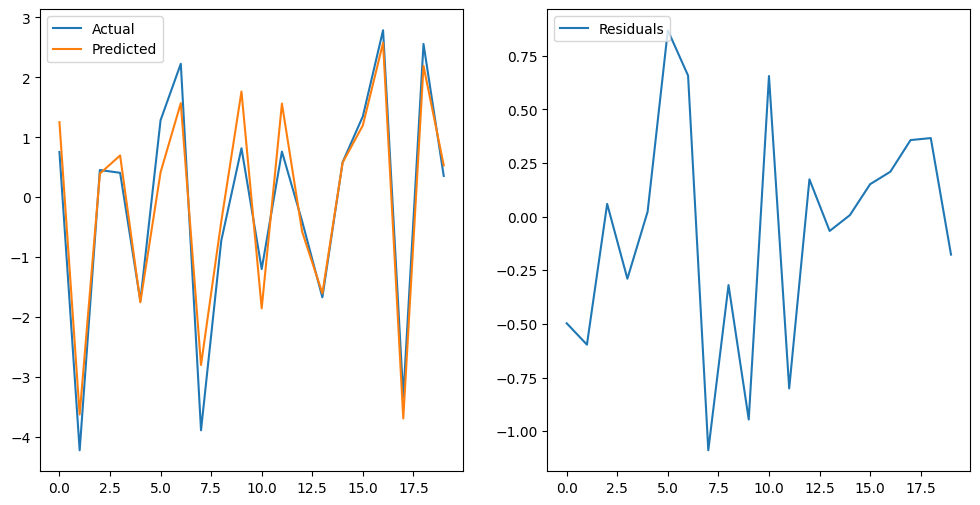

In [68]:
import matplotlib.pyplot as plt

ypoints_R = R_0
ypoints_pR = pR_0
ypoints_residuals = residuals
x = np.arange(len(ypoints_R))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))


ax1.plot(x, ypoints_R, label="Actual")
ax1.plot(x, ypoints_pR, label="Predicted")
ax1.legend(loc="upper left")
ax2.plot(x, ypoints_residuals, label="Residuals")
ax2.legend(loc="upper left")

plt.show()

Great, mumbo wumbo. Now lets plot all five returns.

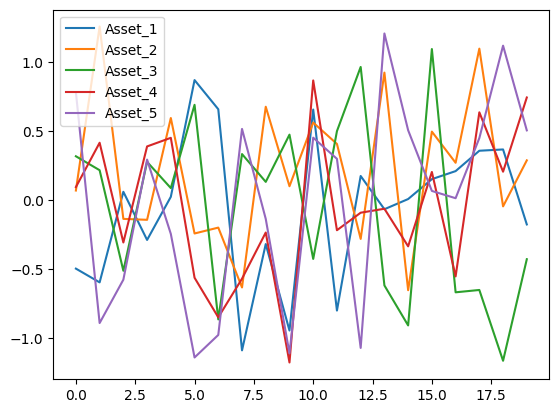

In [102]:
# Calculate residuals
residuals = np.array([r - p for r, p in zip(R, pR)])
xlen = np.arange(len(residuals))

asset_res = {}
for i in range(len(residuals[0])):
    asset_name = f'Asset_{i+1}'
    asset_list = []
    for r in range(len(residuals)):
        asset_list.append(residuals[r][i])
    asset_res[asset_name] = asset_list

for asset, values in asset_res.items():
    plt.plot(values, label=asset)

plt.legend()
plt.show()

Just having a bit of fun with that one.